# Adding Early Stopping Regularization to apparatus-3

## Objectives

- ~~Switch from `read` to `read_up_to` for (hopefully) faster reading~~ \**This didn't work out so well. See apparatus-4-read_up_to-attempt.ipynb.*
- Early-stopping regularization
- Replace tf.train.Supervisor (since it's unofficially deprecated) with the more primitive classes and functions (like Chip Huyen does):
    - tf.Session
    - tf.train.write_graph()
    - tf.summary.FileWriter
    - tf.train.Saver

From apparatus-3 we inherit the following:
- Logistic Regression with 
- Pausable/reloadable sessions using `tf.train.Supervisor.managed_session()`
- High-volume CSV Input Pipeline.
- TensorBoard monitoring

As in previous apparatuses, I've removed some of the leftover bulk (explanation and sanity-test print() statements) so that the new additions are easier to see.

## The Input Pipeline

In [1]:
import os
import tensorflow as tf
notebook_dir = 'bigcluster_parted/train'
g = tf.Graph()

### Mini-batch Design Matrix

Get the list of .csv files in the `notebook_dir`.

In [2]:
csv_file_list = [os.path.join(notebook_dir, x) for x in os.listdir(notebook_dir) if x.endswith('.csv')]

Add operations to the graph which prepare mini-batches.

In [3]:
BATCH_SIZE = 3

with g.as_default():
    
    # Create a queue of the filenames
    filename_queue = tf.train.string_input_producer(csv_file_list)

    # (if there are lines of metadata at the top of the file, we can skip them using this parameter)
    reader = tf.TextLineReader(skip_header_lines=0)
    
    # Create graph operations to read a line from a CSV file (key is optional, but yields good info)
    key, line_from_file = reader.read(filename_queue)
    
    # Specify the default field values (in case they're missing) and their type
    record_defaults = [[0.5], [0.5], [tf.to_int32(0)]]
    
    # Parse the CSV string into an example tensor [x, y, label]
    example = tf.decode_csv(line_from_file, record_defaults=record_defaults)
    
    # Split the example into a feature vector and a label.
    # Add the extra 1 so we can apply bias via matrix multiplication (this extra 1 used to be right in the CSV file)
#     features = example[:2] + [1.0]
    features = tf.stack([example[0], example[1], tf.ones([], tf.float32)], axis=0)
    label = example[-1]
    
    # Graph operations that produce a mini-batch (key batch is optional)
    key_batch, data_batch, label_batch = tf.train.shuffle_batch(
        [key, features, label], 
        batch_size=BATCH_SIZE, 
        capacity=400, 
        min_after_dequeue=100)
    
# g.finalize()

#### Quick check that the extra 1 is added properly

In [4]:
# with tf.Session(graph=g) as s:
#     s.run(tf.global_variables_initializer())
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord, sess=s)
    
#     for i in range(20):
#         print("i = " + str(i))
#         for j in range(BATCH_SIZE):
#             print(s.run([data_batch[j], label_batch[j]]))

#     coord.request_stop()
#     coord.join(threads)

## Logistic Regression

See `apparatus-2.ipynb` for discussion of the math behind logistic regression with stochastic gradient descent.

### Trainable Parameters: $\boldsymbol \theta = (\theta_0, \theta_1, \theta_2) \in \mathbb R^3$

In [5]:
with g.as_default():
    theta = tf.get_variable(name="theta", 
                            shape=[3], 
                            initializer=tf.random_normal_initializer(mean=0, stddev=1, seed=None, dtype=tf.float32),
                            dtype=tf.float32)
    print(theta)

<tf.Variable 'theta:0' shape=(3,) dtype=float32_ref>


Let's do a quick check to make sure theta looks right when it's initialized.  If you get all zeroes, check the console for error messages.  Sometimes it fails to allocate GPU memory for whatever reason. 

In [6]:
with tf.Session(graph=g) as s:
    tf.global_variables_initializer().run()  # Necessary?  Yes!  This is how theta gets initialized
    print(s.run([theta]))

[array([-1.41376936, -0.25148967,  0.72350842], dtype=float32)]


### Training Operation

In [7]:
# learning_rate = 0.01
with g.as_default():

    # Step counter
    global_step = tf.Variable(0, name="global_step", trainable=False, dtype=tf.int32)

    # NEW: decaying learning rate!
    learning_rate = 0.01 * 0.99 ** tf.cast(global_step, tf.float32)

    # Compute the hidden layer output (pre-sigmoid function)
    logits = tf.reshape(tf.matmul(data_batch, theta[:,None]), [-1])
    
    # Compute the loss of each example in the mini-batch
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(label_batch, tf.float32), logits=logits)
    
    # Find the mean loss of the mini-batch
    loss = tf.reduce_mean(losses)
    
    # Train Op
    train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)

### TensorBoard Summaries

In [8]:
with g.as_default():
    with tf.name_scope("summaries"):
        tf.summary.scalar("loss", loss)
        tf.summary.scalar("theta0", theta[0])
        tf.summary.scalar("theta1", theta[1])
        tf.summary.scalar("theta2", theta[2])
        tf.summary.histogram("histogram_loss", loss)
        tf.summary.histogram("histogram_theta0", theta[0])
        tf.summary.histogram("histogram_theta1", theta[1])
        tf.summary.histogram("histogram_theta2", theta[2])
        summary_op = tf.summary.merge_all()

In [9]:
with tf.Session(graph=g) as s:
    s.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=s)
    
    for i in range(500):
        t_op, ls, gstep = s.run([train_op, loss, global_step])
        if (i % 100 == 0):
            print("step %3d:\tloss = %f" % (gstep, ls))

    coord.request_stop()
    coord.join(threads)

step   1:	loss = 1.084977
step 101:	loss = 0.928303
step 201:	loss = 0.594622
step 301:	loss = 0.855208
step 401:	loss = 0.869272


### Training Session

Our queue runners will be sampling stochastically with replacement from the whole pool of input data for each batch.  That means--unlike a scheme in which all the training data is permuted--we don't have proper epochs.  What we'll do instead is measure the size of the pool and take an "epoch" to be simply that many examples (even if some examples are missed while others are sampled more than once during an "epoch" of training).

In [10]:
import subprocess  # need this to run the `wc` utility in bash 
import numpy as np

# Get a string containing the input filenames as a space-delimited list
csv_list_str = " ".join(csv_file_list)

# Find out how many training examples there are, altogether (by counting the lines in the files)
training_pool_size = int(subprocess.check_output("cat " + csv_list_str + " | wc -l", shell=True).decode('UTF-8'))
batches_per_epoch = int(np.ceil(training_pool_size / BATCH_SIZE))

This is where we used to have a `managed_session()`.

**BEFORE RUNNING THE NEXT CELL**:
- run `tensorboard --logdir ./apparatus-4 &` in a bash terminal
- Have this command ready to go:
```
touch ./apparatus-4/pause
```

In [11]:
import time
NOTEBOOK_DIR = "apparatus-4"
pause_file = os.path.join(NOTEBOOK_DIR, "pause")
checkpoint_file = os.path.join(NOTEBOOK_DIR, "model.ckpt")
status_report_freq = 1  # number of seconds btw training status updates
chkpt_freq = 1          # number of seconds btw saved checkpoints

g.add_to_collection('theta', theta)

# sv = tf.train.Supervisor(logdir=NOTEBOOK_DIR, graph=g, save_model_secs=0.01, 
#                          save_summaries_secs=0.01,        
#                          summary_op=summary_op)           

# NEW: Save the "metagraph" (or, as TensorFlow calls it, the "graph")
tf.train.write_graph(graph_or_graph_def=g, logdir=NOTEBOOK_DIR, name="graph.pb", as_text=False)

with tf.Session(graph=g) as s:

    # summary_writer feeds TensorBoard
    summary_writer = tf.summary.FileWriter(logdir=NOTEBOOK_DIR, graph=g, 
                                           flush_secs=1)   # how often to write a summary update
    # Saver for checkpoints
    saver = tf.train.Saver()

    # Must initialize since we're not using managed_seesion
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=s)

    last_chkpt_time = time.time()
    while not tf.gfile.Exists(pause_file):
        
        # Train uninterrupted for one epoch
        for i in range(batches_per_epoch):
            t_op, ls, gstep, summary_op_result = s.run([train_op, loss, global_step, summary_op])
        
        # Save a checkpoint if we're overdue
        if (time.time() - last_chkpt_time > chkpt_freq):
            last_chkpt_time = time.time()
            saver.save(s, checkpoint_file, global_step=gstep)
            summary_writer.add_summary(summary_op_result, global_step=gstep)
            print("step %3d:\tloss = %f" % (gstep, ls))

    coord.request_stop()
    coord.join(threads)
    
    if tf.gfile.Exists(pause_file):
        print("Pause command received.  Saving checkpoint and shutting down.")
        tf.gfile.Remove(pause_file)
        saver.save(s, checkpoint_file, global_step=global_step)

step 600:	loss = 0.836805
step 1200:	loss = 0.467532
step 1800:	loss = 0.639374
step 2400:	loss = 0.729512
step 3000:	loss = 0.621508
step 3600:	loss = 0.479164
step 4200:	loss = 1.057318
step 4800:	loss = 0.672554
step 5400:	loss = 0.863057
step 6000:	loss = 0.541828
step 6400:	loss = 0.845592
step 6600:	loss = 0.692162
step 7200:	loss = 0.579361
step 7400:	loss = 0.852408
step 7800:	loss = 0.608957
step 8400:	loss = 0.923155
step 9200:	loss = 0.813072
step 9800:	loss = 0.977692
step 10400:	loss = 0.672971
step 11200:	loss = 0.863257
step 12000:	loss = 0.919948
step 12800:	loss = 0.942397
step 13600:	loss = 0.935185
step 14400:	loss = 0.733369
step 15200:	loss = 0.726677
step 15800:	loss = 0.671930
step 16400:	loss = 0.981845
step 17000:	loss = 0.901816
step 17800:	loss = 0.666230
step 18600:	loss = 0.672207
step 19400:	loss = 0.675134
step 20000:	loss = 0.691467
step 20600:	loss = 0.993088
step 21200:	loss = 0.924218
step 22000:	loss = 0.596182
step 22800:	loss = 0.807778
step 23400:

### Pick up where we left off
Note the last reported `step` in the previous cell and then run it again.  Observe that training has begun at `last step + 100`.  You can even reboot the computer and rerun the notebook.  It'll still resume where it left off (as long as the training directory isn't wiped). 

In [11]:
# Kill the kernel, forcing it to restart
import os
#os._exit(0)

## Training Analysis

Get a list of the save files available.

In [1]:
import os

NOTEBOOK_DIR = "apparatus-4"

# Grab the most recent metagraph file
metagraph_files = [os.path.join(NOTEBOOK_DIR, x) for x in os.listdir(NOTEBOOK_DIR) if x.endswith('.meta')]
metagraph_files.sort()
metagraph_file = metagraph_files[-1]

# Grab the most recent graph file
graph_file = os.path.splitext(metagraph_file)[0]

print(metagraph_file, graph_file)

apparatus-3/model.ckpt-3230.meta apparatus-3/model.ckpt-3230


### Plot the trained dividing line

It's nice to see the loss going down, but what does the $\theta$ line actually look like?  To access the last value of $\theta$, we need to retrieve it from a `managed_session` again.

In [2]:
import tensorflow as tf

with tf.Session() as s:
    new_saver = tf.train.import_meta_graph(metagraph_file)
    new_saver.restore(s, graph_file)
    theta = tf.get_collection('theta')
    np_theta = s.run(theta)
print(np_theta)

INFO:tensorflow:Restoring parameters from apparatus-3/model.ckpt-3230
[array([ 2.01390958,  1.93738866, -1.75411379], dtype=float32)]


TensorFlow has the value of $\theta$ wrapped in a tensor together with its metadata (the type).  The tuple we need is in that first element.

In [3]:
print(np_theta[0])

[ 2.01390958  1.93738866 -1.75411379]


How do those three components of $\theta$ describe the dividing line between classes?  Well, to classify a point $u$ we look at the sign of $$\langle u, \theta \rangle = u_0 \theta_0 + u_1 \theta_1 + \theta_2$$

When $u$ is right *on* the dividing line that inner product is 0.  To draw this line using `matplotlib`, we need two distinct points it intersects: two solutions of the following expression (in which we assume that $(\theta_0, \theta_1) \neq (0,0)$):
$$u_0 \theta_0 + u_1 \theta_1 = -\theta_2$$

If $\theta_1 = 0$ then the dividing line is $$\left\{\left(-\frac {\theta_2} {\theta_0}, y\right) : y\in\mathbb R\right\}$$
Otherwise, the dividing line is $$\left\{\left(x, -\frac {\theta_2 + x \, \theta_0} {\theta_1} \right) : x\in\mathbb R\right\}$$

In [4]:
# We'll take left border = -1, right border = 2, top border = 2, bottom border = -1
if np_theta[0][1] == 0:
    l0 = [-np_theta[0][2] / np_theta[0][0], -1]
    l1 = [-np_theta[0][2] / np_theta[0][0], 2]
else:
    l0 = [-1, -(np_theta[0][2] - np_theta[0][0]) / np_theta[0][1]]
    l1 = [2,  -(np_theta[0][2] + 2.0 * np_theta[0][0]) / np_theta[0][1]]

In [5]:
print(l0, l1)

[-1, 1.9448981] [2, -1.1735927911368906]


### Read in the CSV files

In [6]:
DATA_DIR = 'bigcluster_parted'
TEST_DIR = os.path.join(DATA_DIR, 'test')
csv_file_list = [os.path.join(TEST_DIR, x) for x in os.listdir(TEST_DIR) if x.endswith('.csv')]
csv_file_list

['bigcluster_parted/test/24.csv',
 'bigcluster_parted/test/5.csv',
 'bigcluster_parted/test/22.csv',
 'bigcluster_parted/test/15.csv',
 'bigcluster_parted/test/1.csv',
 'bigcluster_parted/test/23.csv',
 'bigcluster_parted/test/7.csv',
 'bigcluster_parted/test/4.csv',
 'bigcluster_parted/test/17.csv',
 'bigcluster_parted/test/3.csv',
 'bigcluster_parted/test/25.csv',
 'bigcluster_parted/test/27.csv',
 'bigcluster_parted/test/14.csv',
 'bigcluster_parted/test/16.csv',
 'bigcluster_parted/test/2.csv',
 'bigcluster_parted/test/8.csv',
 'bigcluster_parted/test/18.csv',
 'bigcluster_parted/test/21.csv',
 'bigcluster_parted/test/13.csv',
 'bigcluster_parted/test/6.csv',
 'bigcluster_parted/test/12.csv',
 'bigcluster_parted/test/10.csv',
 'bigcluster_parted/test/9.csv',
 'bigcluster_parted/test/0.csv',
 'bigcluster_parted/test/28.csv',
 'bigcluster_parted/test/19.csv',
 'bigcluster_parted/test/11.csv',
 'bigcluster_parted/test/26.csv',
 'bigcluster_parted/test/20.csv']

In [7]:
import numpy as np
rows = np.ones(shape=(0,3), dtype=np.float32)
for csvfile in csv_file_list:
    rows = np.append(rows, np.genfromtxt(csvfile, delimiter=','), axis=0)
points = rows[:,:2] 
labels = rows[:,2]

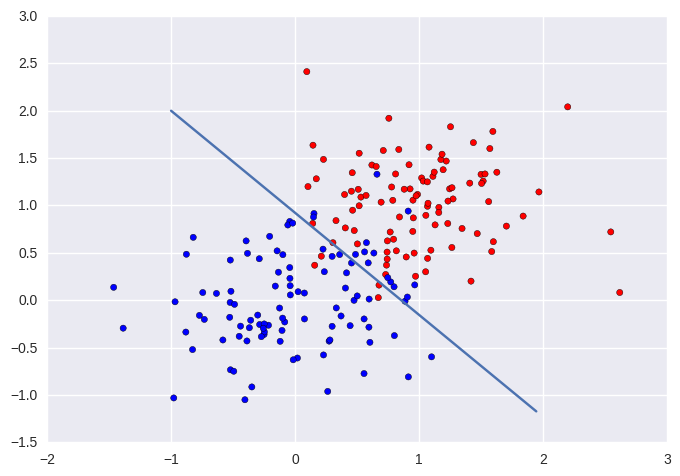

In [8]:
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

vec_colour = np.vectorize(lambda x: ['#0000FF','#FF0000'][int(x)])  # Transform the labels to colours
colour_labels = vec_colour(labels)
plt.scatter(points[:,0], points[:,1], c=colour_labels)
#plt.plot([-1,2], [2,-1])  # This is the line we want a classifier to find
plt.plot(l0, l1)
plt.show()

### Next Objectives
- L2 weight decay regularization
- Dropout regularization (once we add some more layers)
- Autoencoder
- LSTM
- LeNet-5
- t-SNE
- PCA
- XGBoost (outside TensorFlow)
- Look at pandas and see whether there's anything helpful in there